In [19]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from datetime import datetime
from matplotlib import pyplot as plt

In [20]:

NUM_CLASSES = 5
# we need images of same size so we convert them into the size
WIDTH = 128
HEIGHT = 128
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)
# initialize number of epochs to train for, initial learning rate and batch size
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
#global variables
ImageNameDataHash = {}  #dictionary stores the name as key and the actual image data as pair
uniquePatientIDList = []

In [21]:

#reading the train data
def readTrainData(trainDir):
    global ImageNameDataHash
    # loop over the input images
    images = os.listdir(trainDir)
    
    print("Number of files in " + trainDir + " is " + str(len(images)))
    
    for imageFileName in images:
        if (imageFileName == "trainLabels.csv"):
            continue
        # load the image, pre-process it, and store it in the data list
           
        img = load_img(imageFileName)
        arr = img_to_array(img)  
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
       
        #checking if the images are atleast width and height
        if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
            print("Error image dimensions are less than expected "+str(arr.shape))
        
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3)
      
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
            
        # scale the raw pixel intensities to the range [0, 1] - TBD TEST
        arr = np.array(arr, dtype="float") / 255.0
        imageFileName = imageFileName.replace('.jpeg','')
        ImageNameDataHash[str(imageFileName)] = np.array(arr) 
   
    return

print("Loading images at..."+ str(datetime.now()))
readTrainData("train")
print("Loaded " + str(len(ImageNameDataHash)) + " images at..."+ str(datetime.now()))


Loading images at...2022-11-26 10:23:19.763096
Number of files in train is 404
Loaded 404 images at...2022-11-26 10:24:09.314577


In [22]:
#reading the csv file
def readTrainCsv():
    raw_df = pd.read_csv('trainLabels.csv', sep=',')

    raw_df["PatientID"] = ''
    
    ImageLevelHash = {}
    patientIDList = []
    
    #removing the left and right to make a patientID
    for index, row in raw_df.iterrows():
        # 0 is image, 1 is level, 2 is PatientID
        key = row[0] + ''
        patientID = row[0] + ''
        patientID = patientID.replace('_right','')
        patientID = patientID.replace('_left','')
    
        raw_df.at[index, 'PatientID'] = patientID
        patientIDList.append(patientID)
        ImageLevelHash[key] = str(row[1]) # level
                
    global uniquePatientIDList
    uniquePatientIDList = sorted(set(patientIDList))

    return raw_df


In [23]:
print("Reading trainLabels.csv...")
df = readTrainCsv()

Reading trainLabels.csv...


In [24]:
#converging the csv and actual data
# df has 3 columns ['image', 'level', 'PatientID']
keepImages =  list(ImageNameDataHash.keys())
df = df[df['image'].isin(keepImages)]
print(len(df)) # 2000

404


In [25]:
#convert hash to dataframe
imageNameArr = []
dataArr = []
for index, row in df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key])) # np.array


In [26]:
df2 = pd.DataFrame({'image': imageNameArr, 'data': dataArr})        
df = pd.merge(df2, df, left_on='image', right_on='image', how='outer')

C:\Users\HP\AppData\Local\Temp/ipykernel_25084/2511617552.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


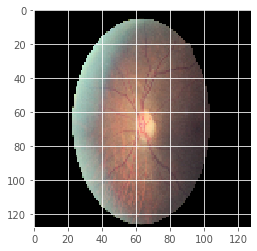

In [27]:
#seeing a sample
sample0 = df.loc[df.index[0], 'data']
plt.imshow(sample0, interpolation='nearest')
plt.show()

In [28]:
# partition the data into training and testing splits using 75% training and 25% for validation
unique_ids = df.PatientID.unique()
train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.25, random_state = 10) #stratify = rr_df['level'])
trainid_list = train_ids.tolist()

In [29]:
traindf = df[df.PatientID.isin(trainid_list)]
valSet = df[~df.PatientID.isin(trainid_list)]

traindf = traindf.reset_index(drop=True)
valSet = valSet.reset_index(drop=True)

trainX = traindf['data']
trainY = traindf['level']

valX = valSet['data']
valY = valSet['level']

In [30]:
trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
valY =  to_categorical(valY, num_classes=NUM_CLASSES)

#reshaping trainX and valX
Xtrain = np.zeros([trainX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(trainX.shape[0]): # 0 to traindf Size -1
    Xtrain[i] = trainX[i]
    
Xval = np.zeros([valX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(valX.shape[0]): # 0 to traindf Size -1
    Xval[i] = valX[i]

In [31]:
#construct the image generator for data augmentation
print("Generating images...")
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

Generating images...


In [32]:
#create the CNN model    
def createModel():
    model = Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    # returns our fully constructed deep learning + Keras image classifier 
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # use binary_crossentropy if there are two classes
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [33]:
# initialize the model
model = createModel()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)       

C:\Users\HP\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [34]:
# train the network
H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \
    validation_data=(Xval, valY), \
    validation_steps = len(Xval) // BS,steps_per_epoch=len(trainX) // BS, \
    epochs=EPOCHS, verbose=1)
print("Testing - :\n")
T = model.evaluate(aug.flow(Xval, valY, batch_size=BS))

Epoch 1/15


C:\Users\HP\AppData\Local\Temp/ipykernel_25084/3047238463.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \


9/9 [==============================] - 3s 292ms/step - loss: 1.1105 - accuracy: 0.6333 - val_loss: 1.1719 - val_accuracy: 0.7451
Epoch 2/15
9/9 [==============================] - 3s 294ms/step - loss: 0.9137 - accuracy: 0.7326 - val_loss: 1.0993 - val_accuracy: 0.7451
Epoch 3/15
9/9 [==============================] - 3s 280ms/step - loss: 0.8607 - accuracy: 0.7519 - val_loss: 0.9132 - val_accuracy: 0.7451
Epoch 4/15
9/9 [==============================] - 3s 280ms/step - loss: 0.9586 - accuracy: 0.7222 - val_loss: 1.1818 - val_accuracy: 0.7451
Epoch 5/15
9/9 [==============================] - 3s 289ms/step - loss: 0.9542 - accuracy: 0.7111 - val_loss: 0.9387 - val_accuracy: 0.7451
Epoch 6/15
9/9 [==============================] - 3s 333ms/step - loss: 0.9210 - accuracy: 0.7185 - val_loss: 0.9771 - val_accuracy: 0.7451
Epoch 7/15
9/9 [==============================] - 3s 285ms/step - loss: 0.9249 - accuracy: 0.7111 - val_loss: 0.9528 - val_accuracy: 0.7451
Epoch 8/15
9/9 [===============

Generating plots...


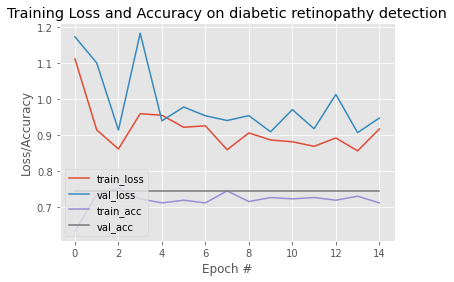

In [35]:
# plot the training loss and accuracy
print("Generating plots...")
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")    
